In [76]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets, models
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import warnings
warnings.filterwarnings('ignore')
import os
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


Batch:1
0:	 Label =  Apple 	Classification = Apple
1:	 Label =  Apple 	Classification = Apple
2:	 Label =  Apple 	Classification = Apple
3:	 Label =  Not-Apple 	Classification = Not-Apple
4:	 Label =  Apple 	Classification = Apple
5:	 Label =  Apple 	Classification = Apple
6:	 Label =  Apple 	Classification = Apple
7:	 Label =  Not-Apple 	Classification = Not-Apple
8:	 Label =  Not-Apple 	Classification = Not-Apple
9:	 Label =  Not-Apple 	Classification = Not-Apple
10:	 Label =  Not-Apple 	Classification = Not-Apple
11:	 Label =  Apple 	Classification = Apple
12:	 Label =  Not-Apple 	Classification = Not-Apple
13:	 Label =  Apple 	Classification = Apple
14:	 Label =  Apple 	Classification = Apple
15:	 Label =  Not-Apple 	Classification = Not-Apple
16:	 Label =  Not-Apple 	Classification = Apple 		Misclassified
17:	 Label =  Not-Apple 	Classification = Not-Apple
18:	 Label =  Not-Apple 	Classification = Not-Apple
19:	 Label =  Apple 	Classification = Apple


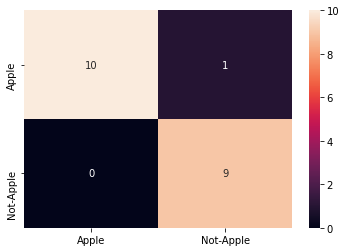


Accuracy:0.949999988079071


In [86]:
# Test: folder with 20 elements for testing

data_dir = 'Apple_Notapple_data/Test'

if len(os.listdir(data_dir + '/Apple')) == 0 and len(os.listdir(data_dir + '/Notapple')) == 0:
    print(str(data_dir) + " is empty")
else:    
    test_transforms = transforms.Compose([transforms.Resize(255),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.5, 0.5, 0.5],
                                                               [0.5, 0.5, 0.5])])

    test_data = datasets.ImageFolder(data_dir, transform=test_transforms)
    testloader = torch.utils.data.DataLoader(test_data, batch_size=50, shuffle=True)
    
    model = torch.load('AppleClassifier.pth')
    model.load_state_dict(torch.load('apple_classifier.pt'))
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    criterion = nn.NLLLoss()

    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
    
    tP = 0
    fP = 0
    fN = 0
    tN = 0

    test_loss = 0
    accuracy = 0
    count = 0
    model.eval()
 
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)
                    
            test_loss += batch_loss.item()
                    
            # Calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            count += 1
            print('\nBatch:' + str(count))

            for i, top in enumerate(top_class):
                if equals[i] == True:
                    if top == 0:
                        tP += 1
                        print(str(i) + ':\t Label =  Apple \tClassification = Apple')
                    else: 
                        tN += 1
                        print(str(i) + ':\t Label =  Not-Apple \tClassification = Not-Apple')
                else:
                    if top == 0:
                        fP += 1
                        print(str(i) + ':\t Label =  Not-Apple \tClassification = Apple \t\tMisclassified')
                    else: 
                        fN += 1
                        print(str(i) + ':\t Label =  Apple \tClassification = Not-Apple \tMisclassified')
    
    con_mtx = [[tP, fP],[fN, tN]]
    df_cm = pd.DataFrame(con_mtx, index = [i for i in "Apple Not-Apple".split(' ')],
                         columns = [i for i in "Apple Not-Apple".split(' ')])
    sn.heatmap(df_cm, annot=True)
    plt.show()
    
    print('\nAccuracy:' + str(accuracy/len(testloader)))